In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor

from sklearn.model_selection import cross_val_predict, cross_val_score
import math

In [2]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/MO2/data.csv")
df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [3]:
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
df = df.drop((missing_data[missing_data['Total'] > 1]).index,axis=1)
#df = df.drop(df.loc[df['Electrical'].isnull()].index)
df.sort_values(by = 'GrLivArea', ascending = False)[:2]
df = df.drop(df[df['Id'] == 1299].index)
df = df.drop(df[df['Id'] == 524].index)
df['SalePrice'] = np.log(df['SalePrice'])
df['GrLivArea'] = np.log(df['GrLivArea'])
df['HasBsmt'] = pd.Series(len(df['TotalBsmtSF']), index=df.index)
df['HasBsmt'] = 0
df.loc[df['TotalBsmtSF']>0,'HasBsmt'] = 1
df.loc[df['HasBsmt']==1,'TotalBsmtSF'] = np.log(df['TotalBsmtSF'])
df = pd.get_dummies(df)
df.shape

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


(1458, 222)

## 1 Выделите обучающую и отложенную выборку. Рассмотрим индивидуальные деревья

In [4]:
X = df.drop('SalePrice', axis=1)
y = df['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(df.drop('SalePrice', axis=1), df['SalePrice'], test_size=0.2, random_state=42)


#a. Выполните 5-кратную перекрестную проверку, чтобы определить, какой будет наилучшая максимальная глубина для одного дерева регрессии, используя все признаки обучающего набора.

In [5]:
max_depths = range(1, 11)

scores = []
std_devs = []
for max_depth in max_depths:
    model = DecisionTreeRegressor(max_depth=max_depth)
    scores.append(np.mean(cross_val_score(model, X_train, y_train, cv=5)))
    std_devs.append(np.std(scores))
    print(max_depth, np.mean(cross_val_score(model, X_train, y_train, cv=5)))

depth_accuracy = dict(zip(max_depths, scores))
best_depth = max_depths[np.argmax(scores)]
best_accuracy = depth_accuracy[best_depth]
print(f"Наилучшая максимальная глубина дерева:", best_depth)
print(f"Точность дерева с наилучшей глубиной:", best_accuracy)

1 0.44185029798401904
2 0.5975995735839958
3 0.6558332075608135
4 0.698706888990075
5 0.7063785470192244
6 0.7228668434539942
7 0.7178111037312904
8 0.6985994958579405
9 0.7009499211044028
10 0.6957548930184069
Наилучшая максимальная глубина дерева: 6
Точность дерева с наилучшей глубиной: 0.7203600252414235


#b. Визуализируйте предсказания со средними отклонениями +/- 1 стандартное отклонение во всех наборах перекрестной проверки.


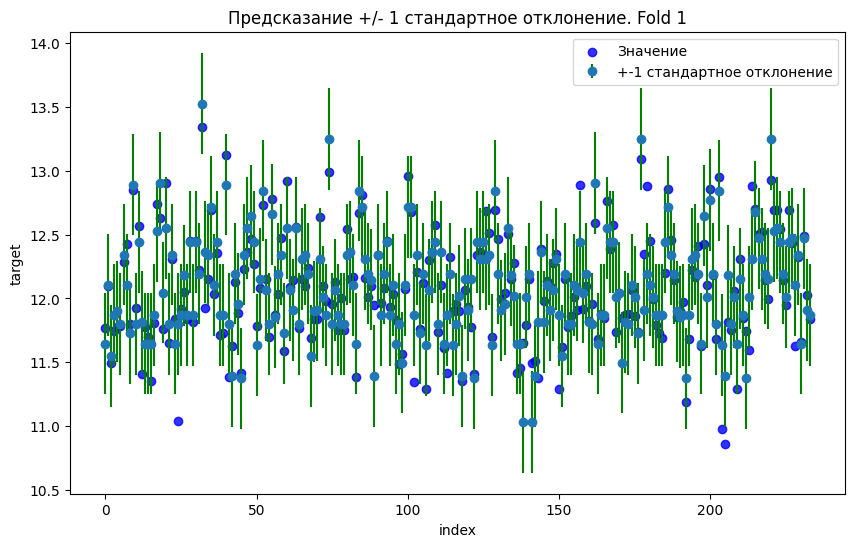

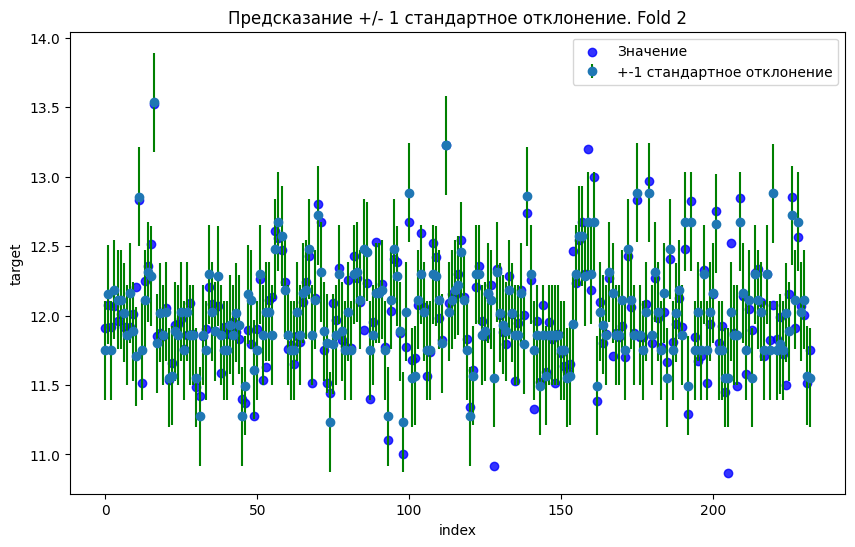

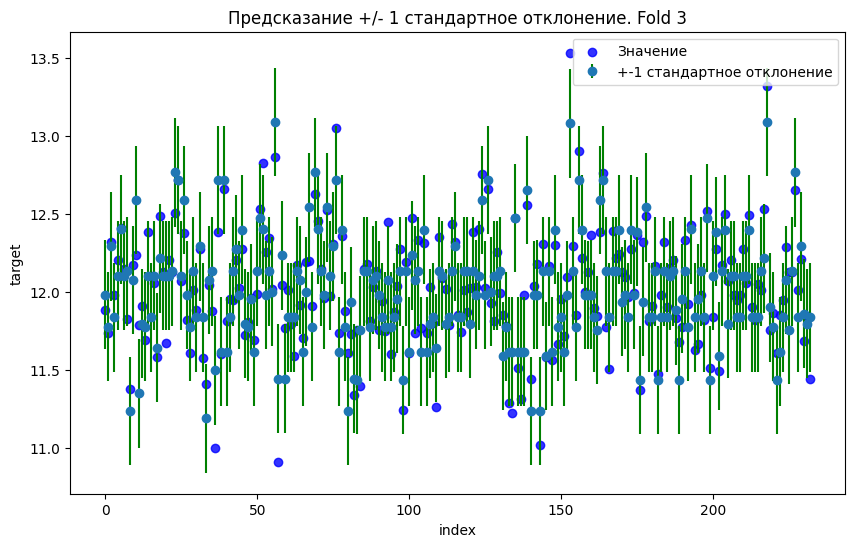

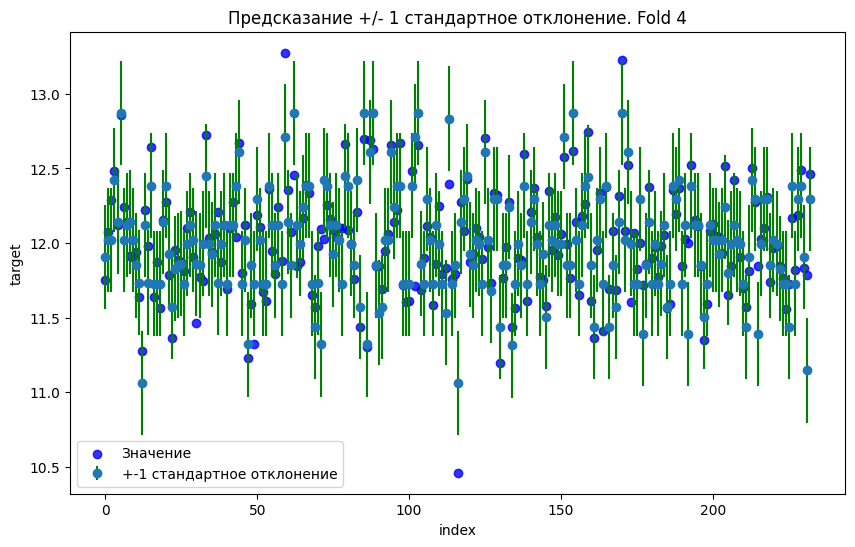

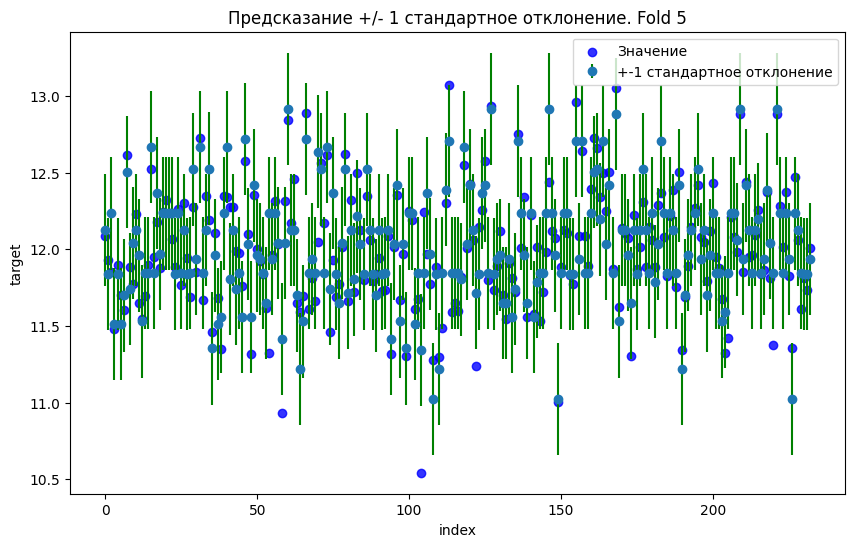

In [6]:
max_depth_range = range(1, 23)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

mean_scores = []
std_devits = []

for max_depth in max_depth_range:
    tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
    scores = cross_val_score(tree, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
    mean_scores.append(np.mean(scores))
    std_devits.append(np.std(scores))

std_devs = []
number_fold = 1

for train_index, test_index in kf.split(X_train):
    X_train1, X_test1 = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train1, y_test1 = y_train.iloc[train_index], y_train.iloc[test_index]

    tree = DecisionTreeRegressor(max_depth=best_depth, random_state=42)
    tree.fit(X_train1, y_train1)
    y_pred = tree.predict(X_test1)
    std_devs = [y_pred.std()]*len(y_pred)
    plt.figure(figsize=(10, 6))
    plt.errorbar(range(len(y_pred)), y_pred, yerr=std_devs, fmt='o', ecolor='g', capthick=2, label='+-1 стандартное отклонение')
    plt.scatter(range(len(y_pred)), y_test1, alpha=0.8, color='blue', label='Значение')
    plt.xlabel('index')
    plt.ylabel('target')
    plt.title(f'Предсказание +/- 1 стандартное отклонение. Fold {number_fold}')
    plt.legend()
    plt.show()
    number_fold += 1


#c. Постройте зависимость точности (+/- 2 стандартных отклонения) от числа деревьев

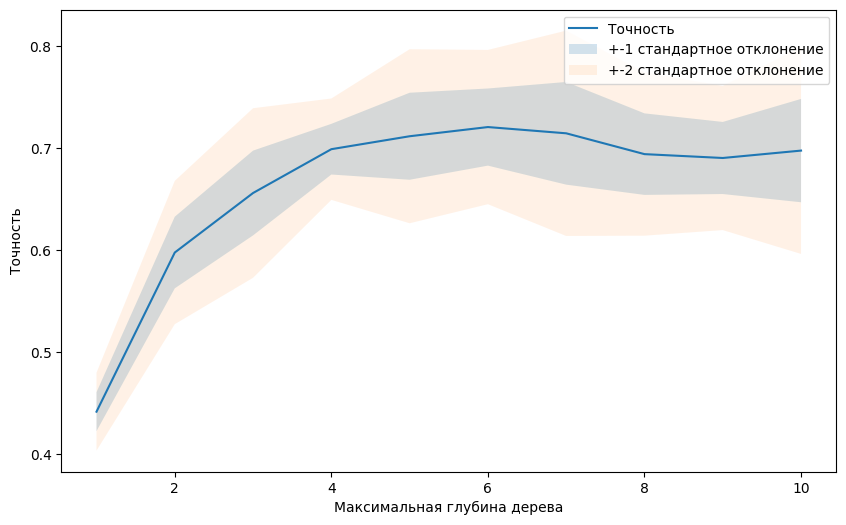

In [7]:
max_depths = range(1, 11)

std_devs = []
for max_depth in max_depths:
    model = DecisionTreeRegressor(max_depth=max_depth)
    scores = cross_val_score(model, X_train, y_train, cv=5)
    std_devs.append(np.std(scores))


depth_accuracy_list = list(depth_accuracy.values())

plt.figure(figsize=(10, 6))
plt.plot(max_depths, depth_accuracy_list, label="Точность")
plt.fill_between(max_depths, np.array(depth_accuracy_list) -  np.array(std_devs), np.array(depth_accuracy_list) + np.array(std_devs), alpha=0.2, label="+-1 стандартное отклонение")
plt.fill_between(max_depths, np.array(depth_accuracy_list) - 2* np.array(std_devs), np.array(depth_accuracy_list) + 2* np.array(std_devs), alpha=0.1, label="+-2 стандартное отклонение")
plt.xlabel("Максимальная глубина дерева")
plt.ylabel("Точность")
plt.legend()
plt.show()

#2 Перейдите к беггингу. C помощью кросс-валидации постройте и обучите несколько отдельных деревьев

In [17]:
X = df.drop('SalePrice', axis=1)
y = df['SalePrice']

n_samples = X.shape[0]
n_trees = 10
np.random.seed(42)
trees = []
indices_list = []
oob_indices_list = []
for i in range(n_trees):
    indices = np.random.choice(n_samples, size=n_samples, replace=True)
    indices_list.append(indices)
    X_bootstrap = X.iloc[indices, :]
    y_bootstrap = y.iloc[indices]

    oob_indices = np.setdiff1d(np.arange(n_samples), indices)
    oob_indices_list.append(oob_indices)

    tree = DecisionTreeRegressor()
    tree.fit(X_bootstrap, y_bootstrap)
    trees.append(tree)

#а. Подведите итоги работы каждого из отдельных деревьев (как численно, так и визуально) с помощью R^2

In [31]:
from sklearn.metrics import r2_score

individual_predictions_oob = []
cv_scores = []
oob_true_values = []
tree_depths = []

for i, tree in enumerate(trees):
    oob_indices = oob_indices_list[i]
    oob_true_values.append(y.iloc[oob_indices])
    individual_predictions_oob.append(tree.predict(X.iloc[oob_indices, :]))
    tree_depths.append(tree.get_depth())

    cv_scores.append(cross_val_score(tree, X.iloc[indices_list[i], :], y.iloc[indices_list[i]], cv=kf, scoring='r2').mean())

for i, (predictions_oob, cv_score, true_values, depth) in enumerate(zip(individual_predictions_oob, cv_scores, oob_true_values, tree_depths)):
    r2_oob = r2_score(true_values, predictions_oob)
    print(f"Tree {i+1}: Depth = {depth}, R^2 (OOB) = {r2_oob:.4f}, R^2 (CV) = {cv_score:.4f}")

Tree 1: Depth = 24, R^2 (OOB) = 0.6997, R^2 (CV) = 0.8695
Tree 2: Depth = 21, R^2 (OOB) = 0.7122, R^2 (CV) = 0.8922
Tree 3: Depth = 21, R^2 (OOB) = 0.6782, R^2 (CV) = 0.8759
Tree 4: Depth = 20, R^2 (OOB) = 0.7172, R^2 (CV) = 0.8504
Tree 5: Depth = 21, R^2 (OOB) = 0.7304, R^2 (CV) = 0.8927
Tree 6: Depth = 23, R^2 (OOB) = 0.6657, R^2 (CV) = 0.8760
Tree 7: Depth = 23, R^2 (OOB) = 0.7001, R^2 (CV) = 0.8540
Tree 8: Depth = 21, R^2 (OOB) = 0.7296, R^2 (CV) = 0.8662
Tree 9: Depth = 24, R^2 (OOB) = 0.6958, R^2 (CV) = 0.8574
Tree 10: Depth = 23, R^2 (OOB) = 0.7426, R^2 (CV) = 0.8522


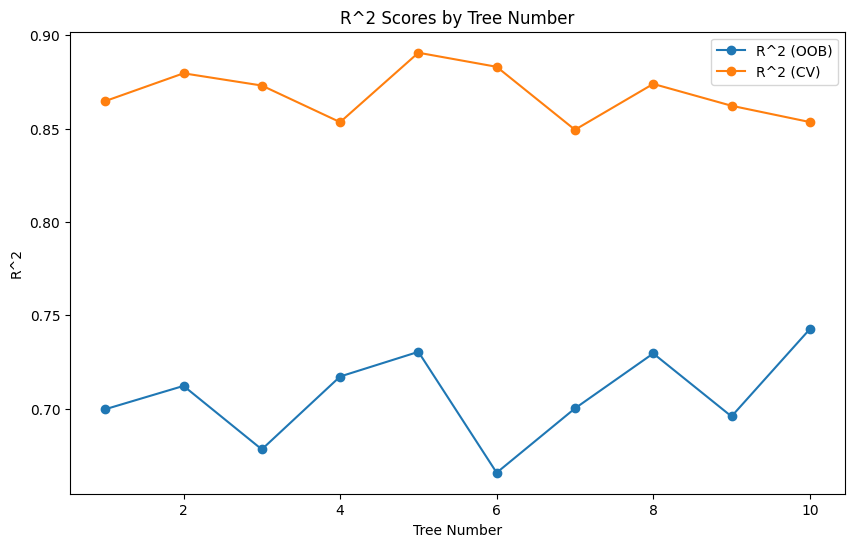

In [19]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(range(1, 11), [r2_score(true_values, predictions_oob) for predictions_oob, true_values in zip(individual_predictions_oob, oob_true_values)], label='R^2 (OOB)', marker='o')
ax.plot(range(1, 11), cv_scores, label='R^2 (CV)', marker='o')
ax.set_xlabel('Tree Number')
ax.set_ylabel('R^2')
ax.set_title('R^2 Scores by Tree Number')
ax.legend()
plt.show()


#b. Объедините деревья в один прогноз с помощью беггинга и оцените его с помощью R^2. Улучшились ли результаты? Оцените, как будет меняться точность в зависимости от глубины. Используйте не только среднее предсказание, но и дисперсию.


Depth: 1, CV score: 0.46080266437091677 (+-6.925570059076996e-15)
Depth: 2, CV score: 0.5925388500022636 (+-4.959638946973109e-15)
Depth: 3, CV score: 0.6736827924500979 (+-3.89645322443474e-15)
Depth: 4, CV score: 0.728092306701713 (+-2.6921630677493007e-15)
Depth: 5, CV score: 0.7502804598189149 (+-0.0010303908336946788)
Depth: 6, CV score: 0.7580912017815953 (+-0.002077854851366122)
Depth: 7, CV score: 0.7705341158653165 (+-0.005296887367874273)
Depth: 8, CV score: 0.7646074050997241 (+-0.011227199688452335)
Depth: 9, CV score: 0.7695703404439864 (+-0.01692905778341197)
Depth: 10, CV score: 0.7695164131077272 (+-0.021766095500559617)
Depth: 11, CV score: 0.7658579321647075 (+-0.026278038386988164)
Depth: 12, CV score: 0.7595741259182736 (+-0.028523625521297443)
Depth: 13, CV score: 0.7607971411139123 (+-0.03094524448132562)
Depth: 14, CV score: 0.7606785714377126 (+-0.03354796706198329)
Depth: 15, CV score: 0.7595113006516172 (+-0.03493235719841937)
Depth: 16, CV score: 0.7621375889

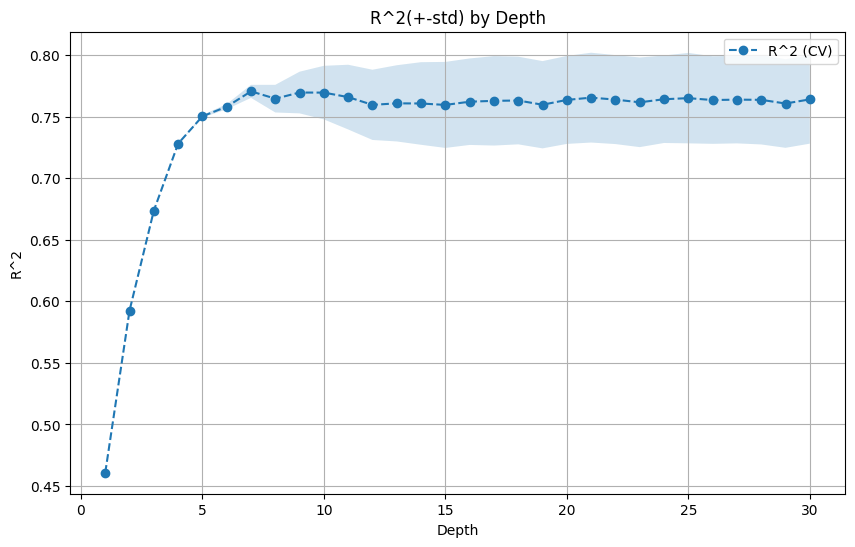

In [21]:
class BaggedTreeRegressor:
    def __init__(self, n_estimators=10, max_depth=None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.trees = []
        self.resampled_indices = []
        self.out_of_bag_indices = []

    def fit(self, X, y):
        n_samples = X.shape[0]

        for i in range(self.n_estimators):
            indices = np.random.choice(n_samples, size=n_samples, replace=True)
            self.resampled_indices.append(indices)

            X_resampled = X.iloc[indices, :]
            y_resampled = y.iloc[indices]

            out_of_bag_indices = np.setdiff1d(np.arange(n_samples), indices)
            self.out_of_bag_indices.append(out_of_bag_indices)

            tree = DecisionTreeRegressor(max_depth=self.max_depth)
            tree.fit(X_resampled, y_resampled)
            self.trees.append(tree)

    def predict_cross_validation(self, X, y, cv):
        cv_predictions = np.zeros((len(y), self.n_estimators))

        for train_index, test_index in cv.split(X):
            train_X, test_X = X.iloc[train_index], X.iloc[test_index]
            train_y, test_y = y.iloc[train_index], y.iloc[test_index]
            fold_predictions = np.zeros((len(test_y), self.n_estimators))
            for i, tree in enumerate(self.trees):
                tree.fit(train_X, train_y)
                fold_predictions[:, i] = tree.predict(test_X)
            cv_predictions[test_index] = fold_predictions

        mean_cv_predictions = np.mean(cv_predictions, axis=1)
        std_cv_predictions = np.std(cv_predictions, axis=1)

        return mean_cv_predictions, std_cv_predictions

max_depths = np.arange(1, 31)

r2_values_cv = []
std_values_cv = []

for depth in max_depths:
    bagged_trees = BaggedTreeRegressor(n_estimators=10, max_depth=depth)
    bagged_trees.fit(X, y)

    cv_predictions, std_cv = bagged_trees.predict_cross_validation(X, y, cv=kf)
    r2_cv = r2_score(y, cv_predictions)
    r2_values_cv.append(r2_cv)
    std_values_cv.append(np.mean(std_cv))
    print(f'Depth: {depth}, CV score: {r2_cv} (+-{np.mean(std_cv)})')

r2_values_cv = np.array(r2_values_cv)
std_values_cv = np.array(std_values_cv)

print(f'Max R^2 (CV): {np.max(r2_values_cv)} with depth {max_depths[np.argmax(r2_values_cv)]}')

plt.figure(figsize=(10, 6))
plt.plot(max_depths, r2_values_cv, marker='o', label='R^2 (CV)', linestyle='--')
plt.fill_between(max_depths, r2_values_cv - std_values_cv, r2_values_cv + std_values_cv, alpha=0.2, linestyle='--')
plt.xlabel('Depth')
plt.ylabel('R^2')
plt.title('R^2(+-std) by Depth')
plt.legend()
plt.grid(True)
plt.show()

#c. Постройте графики зависимости bias-variance в зависимости от числа деревьев (до 500 деревьев)




n_estimators: 5, Bias^2: 0.0399, Variance: 0.0005
n_estimators: 10, Bias^2: 0.0399, Variance: 0.0013
n_estimators: 50, Bias^2: 0.0399, Variance: 0.0010
n_estimators: 100, Bias^2: 0.0399, Variance: 0.0011
n_estimators: 200, Bias^2: 0.0399, Variance: 0.0011
n_estimators: 500, Bias^2: 0.0399, Variance: 0.0011


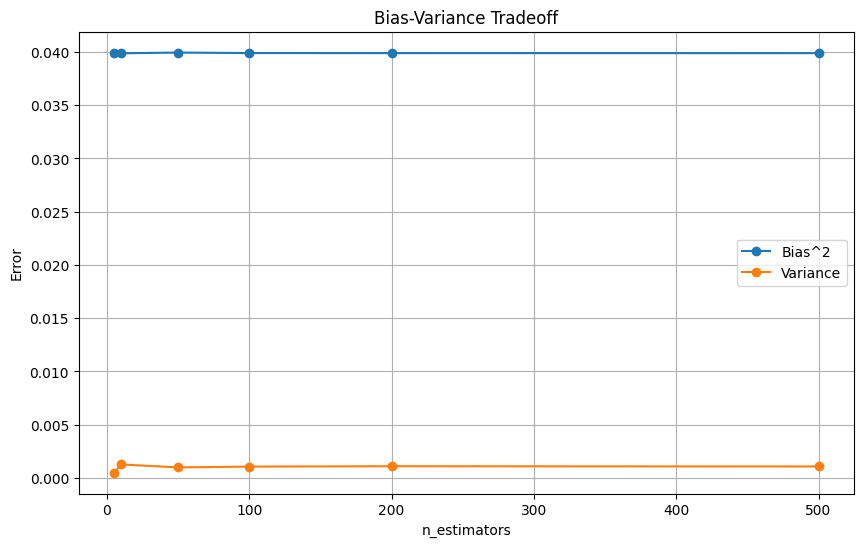

In [22]:
max_depth = 5
n_estimators_list = [5, 10, 50, 100, 200, 500]
bias_squared_list = []
variance_list = []

for n_estimators in n_estimators_list:
    tree_ensemble = BaggedTreeRegressor(n_estimators=n_estimators, max_depth=max_depth)
    tree_ensemble.fit(X, y)

    mean_predictions, std_predictions = tree_ensemble.predict_cross_validation(X, y, cv=kf)

    avg_bias_squared = np.mean((mean_predictions - y) ** 2)
    avg_variance = np.mean(std_predictions)
    print(f'n_estimators: {n_estimators}, Bias^2: {avg_bias_squared:.4f}, Variance: {avg_variance:.4f}')

    bias_squared_list.append(avg_bias_squared)
    variance_list.append(avg_variance)

plt.figure(figsize=(10, 6))
plt.plot(n_estimators_list, bias_squared_list, label='Bias^2', marker='o')
plt.plot(n_estimators_list, variance_list, label='Variance', marker='o')
plt.xlabel('n_estimators')
plt.ylabel('Error')
plt.title('Bias-Variance Tradeoff')
plt.legend()
plt.grid(True)
plt.show()

#3. Повторите предыдущие шаги, но для случайного леса

In [23]:
ensemble_model = RandomForestRegressor(n_estimators=50, oob_score=True, random_state=42)
ensemble_model.fit(X, y)

print("Out-of-Bag Score:", ensemble_model.oob_score_)

cv_score = cross_val_score(ensemble_model, X, y, cv=5, scoring='r2').mean()
print("CV Score:", cv_score)

Out-of-Bag Score: 0.8756274550715228
CV Score: 0.8785328928417242


#a.	Также оцените важность признаков. Какие 5 признаков наиболее


Feature importances:
Feature OverallQual: 0.5506521243601167
Feature GrLivArea: 0.1162278565628254
Feature TotalBsmtSF: 0.05240063174473414
Feature GarageCars: 0.03805194591299271
Feature GarageArea: 0.029456311728808495
Feature BsmtFinSF1: 0.024326149115545353
Feature YearBuilt: 0.022718464862694503
Feature 1stFlrSF: 0.021982301051286398
Feature LotArea: 0.014461371910348908
Feature OverallCond: 0.013195989315745666
Feature YearRemodAdd: 0.010042942088911905
Feature BsmtUnfSF: 0.0061271505891475255
Feature MSZoning_RM: 0.005591884296032824
Feature 2ndFlrSF: 0.0055321446402922
Feature CentralAir_Y: 0.005115092831669081
Feature CentralAir_N: 0.004896741589925987
Feature OpenPorchSF: 0.004451918284477096
Feature Id: 0.0042559060233697335
Feature Fireplaces: 0.004208645917580777
Feature WoodDeckSF: 0.0034706920192740364


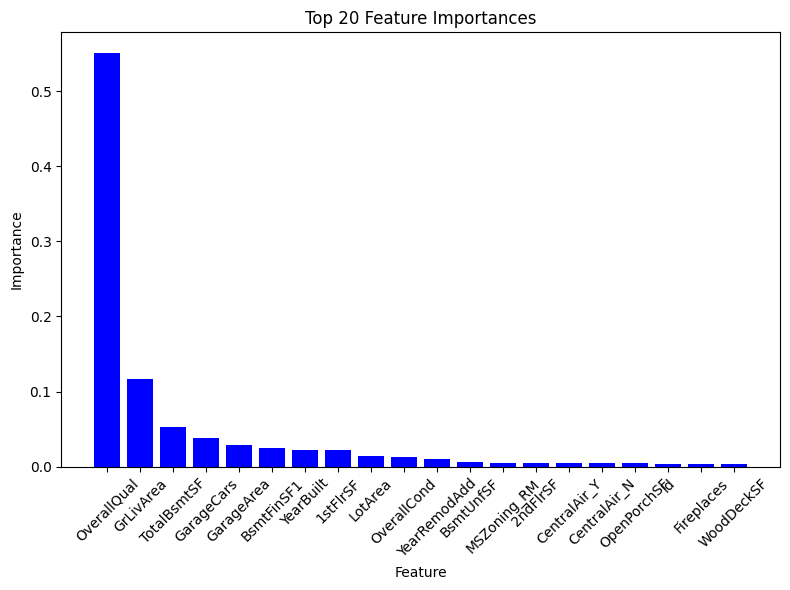

In [24]:
importances = ensemble_model.feature_importances_
indices = np.argsort(importances)[::-1]

print("Feature importances:")
for f in range(20):
    print(f"Feature {X.columns[indices[f]]}: {importances[indices[f]]}")

plt.figure(figsize=(8, 6))
plt.title("Top 20 Feature Importances")
plt.bar(range(20), importances[indices][:20], color="blue", align="center")
plt.xticks(range(20), X.columns[indices][:20], rotation=45)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

#b. Как изменится результат при использовании только 3/5/8 важнейших признаков?

In [25]:
print(f"Out-of-bag score using all features: {ensemble_model.oob_score_:.4f}\n")

top_features = indices[:20]
X_top = X.iloc[:, top_features]

oob_scores = []
cv_scores = []

for num_features in [3, 5, 8]:
    model = RandomForestRegressor(n_estimators=30, random_state=42, oob_score=True)
    model.fit(X_top.iloc[:, :num_features], y)

    oob_scores.append(model.oob_score_)
    cv_scores.append(np.mean(cross_val_score(model, X_top.iloc[:, :num_features], y, cv=kf)))

for num_features, oob_score, cv_score in zip([3, 5, 8], oob_scores, cv_scores):
    print(f"Out-of-bag score using {num_features} most important features: {oob_score:.4f}")
    print(f"CV score using {num_features} most important features: {cv_score:.4f}\n")

Out-of-bag score using all features: 0.8756

Out-of-bag score using 3 most important features: 0.7762
CV score using 3 most important features: 0.7771

Out-of-bag score using 5 most important features: 0.8114
CV score using 5 most important features: 0.8069

Out-of-bag score using 8 most important features: 0.8369
CV score using 8 most important features: 0.8406



#5. Повторите шаги из пункта 3 для AdaBoost. Также постройте зависимость точности от глубины дерева.

n_estimators: 5, Mean R^2: 0.7566 (+-0.0286)
n_estimators: 10, Mean R^2: 0.7842 (+-0.0248)
n_estimators: 50, Mean R^2: 0.8146 (+-0.0184)
n_estimators: 100, Mean R^2: 0.8163 (+-0.0236)
n_estimators: 200, Mean R^2: 0.8186 (+-0.0228)
n_estimators: 500, Mean R^2: 0.8197 (+-0.0229)


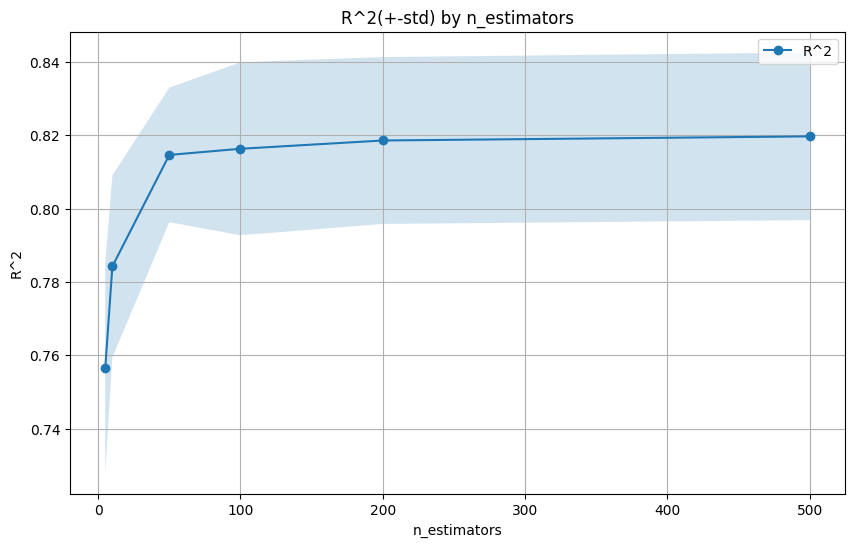

In [26]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
n_estimators_list = [5, 10, 50, 100, 200, 500]

mean_r2_scores = []
std_r2_scores = []

for n_estimators in n_estimators_list:
    model = AdaBoostRegressor(n_estimators=n_estimators, random_state=42)

    scores = cross_val_score(model, X, y, cv=kf, scoring='r2')

    mean_r2_score = np.mean(scores)
    std_r2_score = np.std(scores)
    mean_r2_scores.append(mean_r2_score)
    std_r2_scores.append(std_r2_score)

    print(f'n_estimators: {n_estimators}, Mean R^2: {mean_r2_score:.4f} (+-{std_r2_score:.4f})')

mean_r2_scores = np.array(mean_r2_scores)
std_r2_scores = np.array(std_r2_scores)

plt.figure(figsize=(10, 6))
plt.plot(n_estimators_list, mean_r2_scores, marker='o', label='R^2')
plt.fill_between(n_estimators_list, mean_r2_scores - std_r2_scores, mean_r2_scores + std_r2_scores, alpha=0.2, linestyle='--')
plt.xlabel('n_estimators')
plt.ylabel('R^2')
plt.title('R^2(+-std) by n_estimators')
plt.legend()
plt.grid(True)
plt.show()

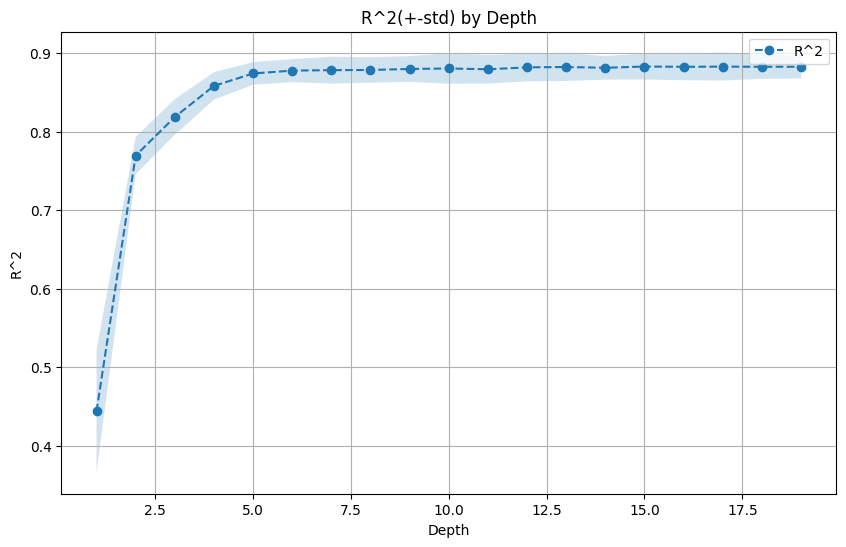

In [27]:
max_depth_list = np.arange(1, 20)
mean_r2_scores = []
std_r2_scores = []

for depth in max_depth_list:
    model = AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=depth), n_estimators=200, random_state=42)
    scores = cross_val_score(model, X, y, cv=kf, scoring='r2')

    mean_r2_score = np.mean(scores)
    std_r2_score = np.std(scores)
    mean_r2_scores.append(mean_r2_score)
    std_r2_scores.append(std_r2_score)

mean_r2_scores = np.array(mean_r2_scores)
std_r2_scores = np.array(std_r2_scores)

plt.figure(figsize=(10, 6))
plt.plot(max_depth_list, mean_r2_scores, marker='o', label='R^2', linestyle='--')
plt.fill_between(max_depth_list, mean_r2_scores - std_r2_scores, mean_r2_scores + std_r2_scores, alpha=0.2, linestyle='--')
plt.xlabel('Depth')
plt.ylabel('R^2')
plt.title('R^2(+-std) by Depth')
plt.legend()
plt.grid(True)
plt.show()

In [28]:
max_r2_score = np.max(mean_r2_scores)
max_depth = max_depth_list[np.argmax(mean_r2_scores)]

print(f'Best R^2: {max_r2_score} with depth {max_depth}')

Best R^2: 0.8828536823704238 with depth 15
